# This script demonstrates the linearization of the "swiss roll" data sets

In [1]:
%matplotlib notebook
import vae_tools # Always import first to define if keras or tf.kreas should be used
import vae_tools.sanity
import vae_tools.viz
import vae_tools.callbacks
from vae_tools.mmvae import MmVae, ReconstructionLoss
vae_tools.sanity.check()
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Input, Dense, Lambda, Layer, Flatten, Reshape
from keras.datasets import mnist
import numpy as np
from scipy.stats import norm
# Set the seed for reproducible results
import vae_tools.sampling
vae_tools.sampling.set_seed(0)
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

Using TensorFlow backend.


python version:  3.5.2
keras version: 2.2.4
tensorflow version: 1.12.0
matplotlib uses:  nbAgg
Available GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


<IPython.core.display.Javascript object>


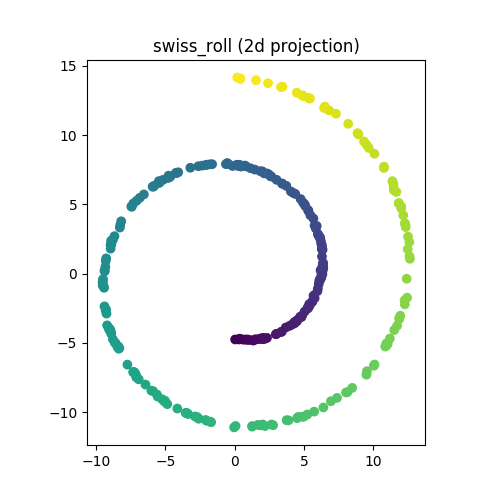

<IPython.core.display.Javascript object>


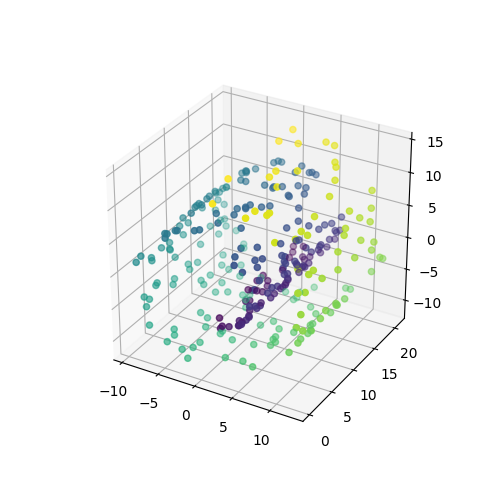

In [12]:
# Get the swiss roll
n_samples = 30000
train_perc = 0.99
n_train_samples = int(n_samples * train_perc)
n_test_samples = int(n_samples - n_train_samples)
x_roll, y_roll = datasets.make_swiss_roll(n_samples=n_samples, noise=0.05)
x_train, y_train, x_test, y_test = x_roll[:n_train_samples], y_roll[:n_train_samples], x_roll[-n_test_samples:], y_roll[-n_test_samples:]

# 2d projection
f, axs = plt.subplots(1,1,figsize=(5,5), dpi=None)
axs.scatter(x_test[:, 0], x_test[:, 2], c=y_test)
axs.set_title("swiss_roll (2d projection)")
axs.set_aspect('equal')
plt.show()

# 3d plot
fig = plt.figure(figsize=(5,5), dpi=None)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_test[:, 0], x_test[:, 1], x_test[:, 2], c=y_test)
fig.show()

In [3]:
# Network structure
batch_size = 1024
original_dim = x_train.shape[1]
intermediate_dim = 256
epochs = 500
z_dim = 2
beta = .01

encoder = [[
    Input(shape=(original_dim,)),                       # Input layer
    Dense(intermediate_dim, activation='relu'),         # First encoder layer
    Dense(int(intermediate_dim/2), activation='relu')   # Second encoder layer
]]

decoder = [[
    Dense(int(intermediate_dim/2), activation='relu'),  # First decoder layer
    Dense(intermediate_dim, activation='relu'),         # Second decoder layer
    Dense(original_dim, activation='linear')            # Output layer
]]

In [4]:
# Get an specilized losslayer for linearization of the swiss roll (Not that special at all, just a demonstration, that one can hand over user-defined losslayers)
class Losslayer(Layer):
    '''Generic loss layer'''
    def __init__(self, **kwargs):
        '''
        weight              : A static weight value which is used if warmup is None
        '''
        self.weight = K.variable(value=kwargs.pop('weight', 1.0))
        self.is_placeholder = True
        super().__init__(**kwargs)
        
    def call(self, inputs):
        '''We assume always a single input and ouput'''
        x = K.flatten(inputs[0]) # Inputs
        x_decoded = K.flatten(inputs[1]) # Output
        
        #reconstruction_loss = self.weight * metrics.mean_squared_error(x, x_decoded)
        # reconstruction_loss = K.minimum(2.0, K.sqrt(K.sum(K.square(x - x_decoded), axis=-1)))
        reconstruction_loss = self.weight * K.sqrt(K.sum(K.square(x - x_decoded), axis=-1))
        ## Define the final loss
        reconstruction_loss = K.sum(reconstruction_loss)
        self.add_loss(reconstruction_loss, inputs=inputs)
        # Return the loss value
        return reconstruction_loss
        

In [5]:
# Build and train the network
vae_obj = MmVae(z_dim, encoder, decoder, [original_dim], beta, reconstruction_loss_metrics = [Losslayer()], name='Vae')

vae = vae_obj.get_model()
vae.compile(optimizer='rmsprop', loss=None)
#vae_tools.viz.plot_model(vae, file = 'myVAE', print_svg = False, verbose = True)

# Store the losses to a history object for plotting
losses_cb = vae_tools.callbacks.Losses(data = x_test)
# Train
vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            verbose = 0,
            callbacks=[losses_cb])

<IPython.core.display.Javascript object>


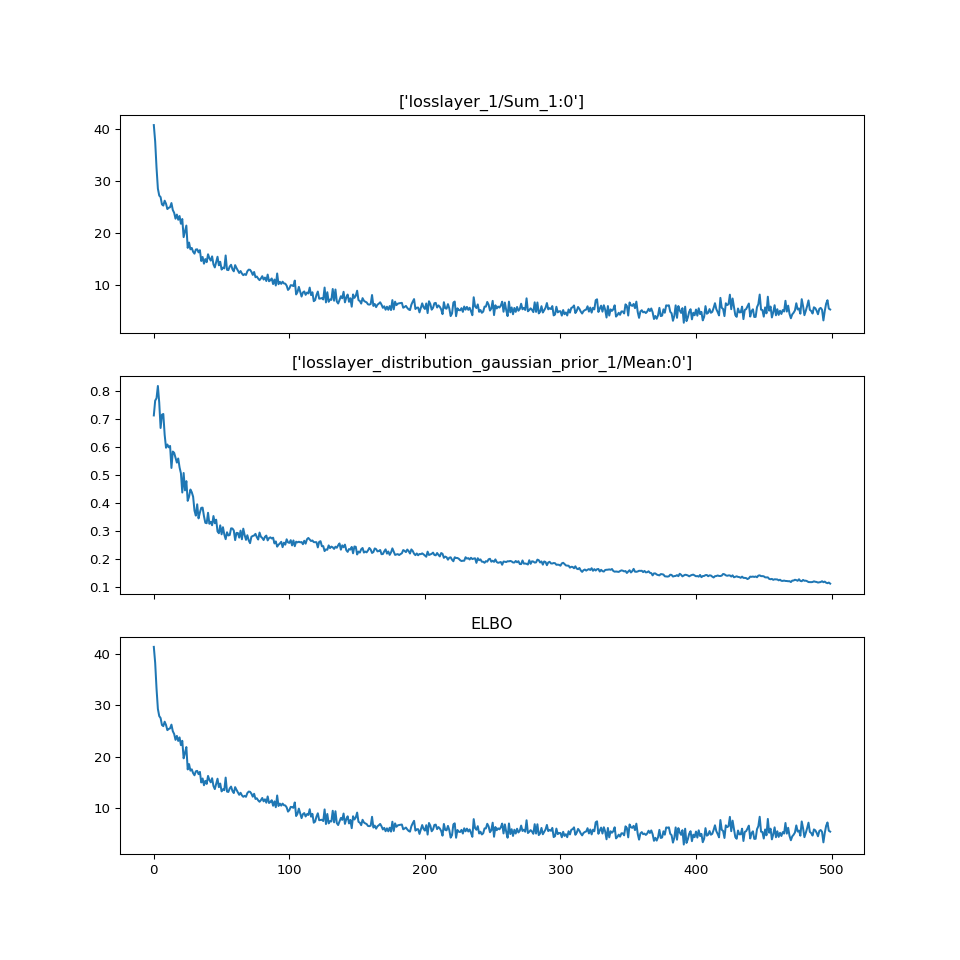

In [11]:
# Show the losses
f, axs = plt.subplots(len(list(losses_cb.history.values()))+1, 1, sharex=True, figsize=[10,10], dpi=96)
for idx in range(len(axs)-1):
    axs[idx].plot(list(losses_cb.history.values())[idx])
    axs[idx].set_title([list(losses_cb.history.keys())[idx]])
axs[-1].plot([sum(values) for values in zip(*list(losses_cb.history.values()))])
axs[-1].set_title("ELBO")
plt.show()

<IPython.core.display.Javascript object>


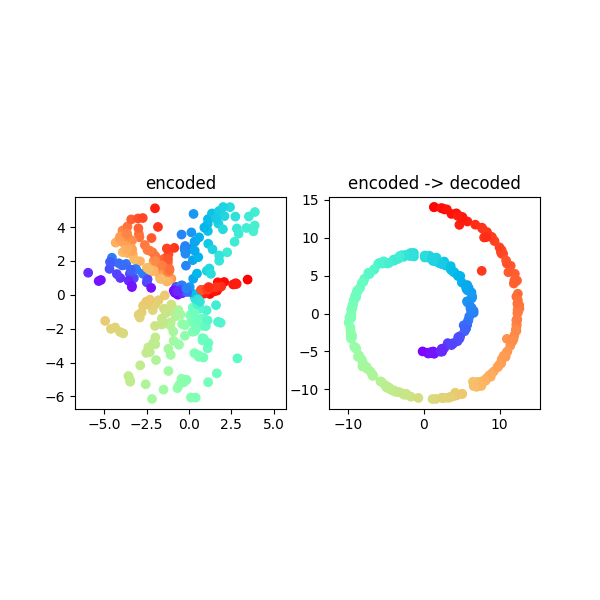

In [10]:
# build a model to project inputs on the latent space
encoder_input = [encoder[0][0]]
encoder_model = vae_obj.get_encoder_mean(encoder_input)
decoder_model = vae_obj.get_decoder()
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)
x_test_decoded = decoder_model.predict(x_test_encoded, batch_size=batch_size)
f, axs = plt.subplots(1,2,figsize=(6, 6))
if x_test_encoded.shape[1] == 2:
    axs[0].scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='rainbow')
else:
    axs[0].scatter(x_test_encoded[:, 0], np.zeros(shape=x_test_encoded[:, 0].shape), c=y_test, cmap='rainbow')
if x_test_decoded.shape[1] == 3:
    axs[1].scatter(x_test_decoded[:, 0], x_test_decoded[:, 2], c=y_test, cmap='rainbow')
else:
    axs[1].scatter(x_test_decoded[:, 0], x_test_decoded[:, 1], c=y_test, cmap='rainbow')
axs[0].set_title("encoded")
axs[1].set_title("encoded -> decoded")
vae_tools.viz.set_xy_equal_lim(np.asarray(axs[0]))
vae_tools.viz.set_xy_equal_lim(np.asarray(axs[1]))
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

plt.show()

First encoder layer


<IPython.core.display.Javascript object>


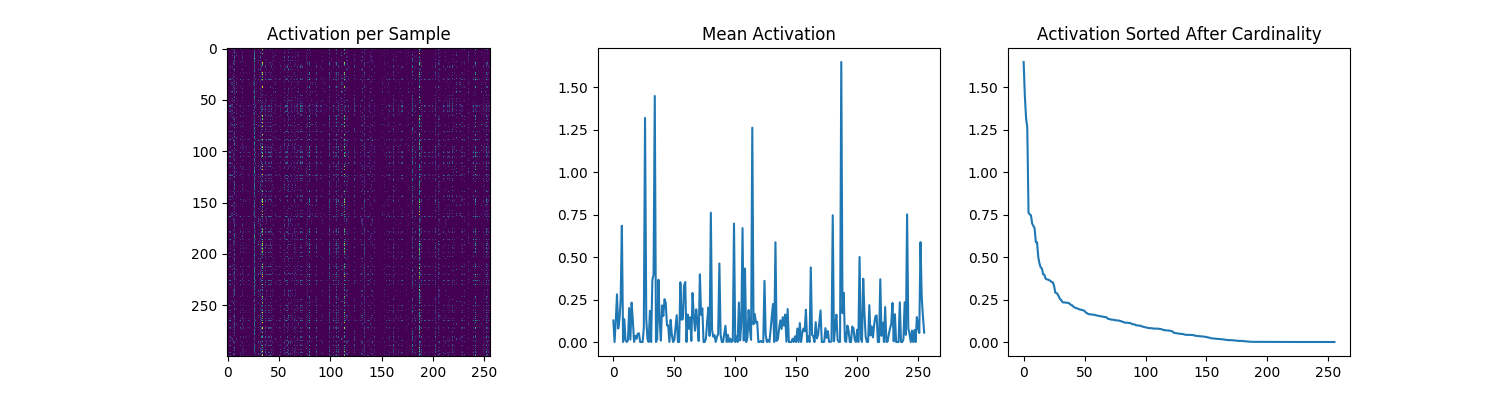

Second encoder layer


<IPython.core.display.Javascript object>


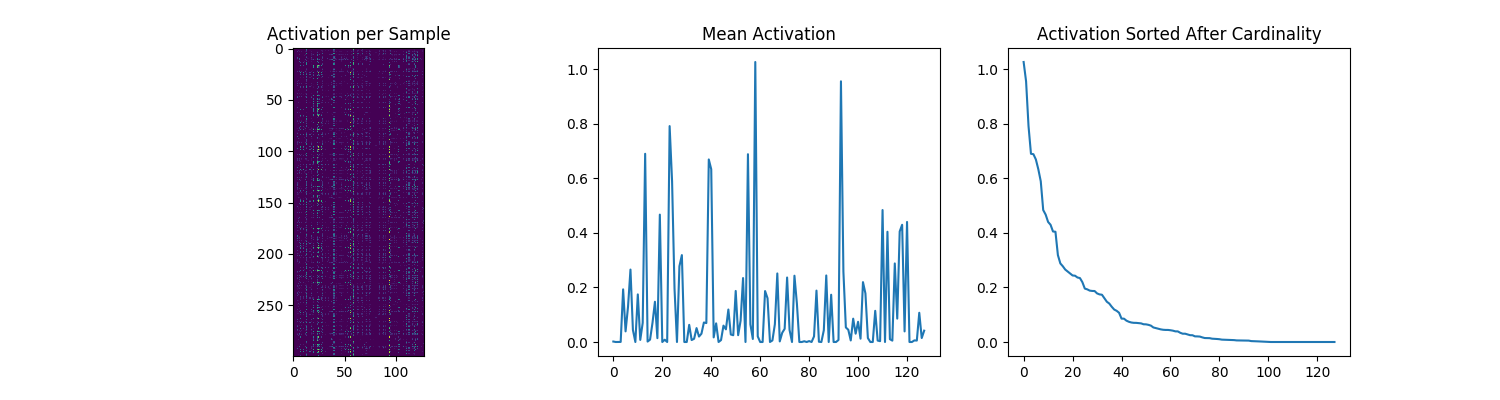

In [9]:
# Get activations for the encoder layers
def plot_layer_activations(layer_activations, x_test):
    f, axs = plt.subplots(1,3,figsize=(15, 4))
    # activation per sample
    axs[0].imshow(layer_activations.predict(x_test))
    axs[0].set_title("Activation per Sample")
    # mean activation
    axs[1].plot(np.mean(layer_activations.predict(x_test), axis=0))
    axs[1].set_title("Mean Activation")
    # Cardinality of all activations
    A = np.mean(layer_activations.predict(x_test), axis=0)
    A.sort()
    axs[2].plot(np.fliplr(A[:,None].T).T)
    axs[2].set_title("Activation Sorted After Cardinality")
    f.show()

print("First encoder layer")
layer_activations = keras.Model(encoder[0][0], encoder[0][1](encoder[0][0]))
plot_layer_activations(layer_activations, x_test)
print("Second encoder layer")
layer_activations = keras.Model(encoder[0][0], encoder[0][2](encoder[0][1](encoder[0][0])))
plot_layer_activations(layer_activations, x_test)